In [10]:
from collections import deque
import math
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.lax as lax
import jax.random as jrandom
import numpy as np
import optax
import distrax
import haiku as hk

import tensorflow as tf
import tensorflow_datasets as tfds

from lfiax.flows.nsf import make_nsf

from typing import (
    Any,
    Iterator,
    Mapping,
    Optional,
    Tuple,
)

Array = jnp.ndarray
PRNGKey = Array
Batch = Mapping[str, np.ndarray]
OptState = Any


def sim_linear_jax(d: Array, priors: Array, key: PRNGKey):
    # Keys for the appropriate functions
    keys = jrandom.split(key, 3)

    # sample random normal dist
    noise_shape = (1,)

    mu_noise = jnp.zeros(noise_shape)
    sigma_noise = jnp.ones(noise_shape)

    n_n = distrax.Independent(
        distrax.MultivariateNormalDiag(mu_noise, sigma_noise)
    ).sample(seed=keys[0], sample_shape=[len(d), len(priors)])

    # sample random gamma noise
    n_g = distrax.Gamma(2.0, 1.0 / 2.0).sample(
        seed=keys[1], sample_shape=[len(d), len(priors)]
    )

    # perform forward pass
    y = jnp.broadcast_to(priors[:, 0], (len(d), len(priors)))
    y = y + jnp.expand_dims(d, 1) @ jnp.expand_dims(priors[:, 1], 0)
    y = y + n_g + jnp.squeeze(n_n)
    ygrads = priors[:, 1]

    return y, ygrads


def sim_true_linear_jax(d: Array, theta_true: Array, key: PRNGKey):
    # TODO: check that `theta_true` is the correct size
    # TODO: check that function works as expected
    # Keys for the appropriate functions
    keys = jrandom.split(key, 3)

    # sample random normal dist
    noise_shape = (1,)

    mu_noise = jnp.zeros(noise_shape)
    sigma_noise = jnp.ones(noise_shape)

    n_n = distrax.Independent(
        distrax.MultivariateNormalDiag(mu_noise, sigma_noise)
    ).sample(seed=keys[0], sample_shape=[len(d), len(theta_true)])

    # sample random gamma noise
    n_g = distrax.Gamma(2.0, 1.0 / 2.0).sample(
        seed=keys[1], sample_shape=[len(d), len(theta_true)]
    )

    # perform forward pass
    y = jnp.broadcast_to(theta_true[:, 0], (len(d), len(theta_true)))
    y = y + jnp.expand_dims(d, 1) @ jnp.expand_dims(theta_true[:, 1], 0)
    y = y + n_g + jnp.squeeze(n_n)
    ygrads = theta_true[:, 1]

    return y, ygrads


def sim_data(d: Array, num_samples: Array, key: PRNGKey):
    """
    Returns data in a format suitable for normalizing flow training.
    Data will be in shape [y, thetas, d]. The `y` variable can vary in size.
    """
    keys = jrandom.split(key, 2)

    theta_shape = (2,)

    mu = jnp.zeros(theta_shape)
    sigma = (3**2) * jnp.ones(theta_shape)

    base_distribution = distrax.Independent(  # Should this be independent?
        distrax.MultivariateNormalDiag(mu, sigma)
    )

    priors = base_distribution.sample(seed=keys[0], sample_shape=[num_samples])

    # ygrads allows to be compared to other implementations (Kleinegesse et)
    y, ygrads = sim_linear_jax(d, priors, keys[1])

    return jnp.column_stack(
        (y.T, jnp.squeeze(priors), jnp.broadcast_to(d, (num_samples, len(d))))
    )


def sim_linear_jax_laplace(d: Array, priors: Array, key: PRNGKey):
    # Keys for the appropriate functions
    keys = jrandom.split(key, 3)

    # sample random normal dist
    noise_shape = (1,)

    concentration = jnp.ones(noise_shape)
    rate = jnp.ones(noise_shape)

    n_n = distrax.Gamma(concentration, rate).sample(seed=keys[0], sample_shape=[len(d), len(priors)])

    # perform forward pass
    y = jnp.broadcast_to(priors[:, 0], (len(d), len(priors)))
    y = distrax.MultivariateNormalDiag(y, jnp.squeeze(n_n)).sample(seed=keys[1], sample_shape=())

    return y


def sim_data_laplace(d: Array, priors: Array, key: PRNGKey):
    """
    Returns data in a format suitable for normalizing flow training.
    Data will be in shape [y, thetas]. The `y` variable can vary in size.
    """
    keys = jrandom.split(key, 2)
    theta_shape = (1,)

    loc = jnp.zeros(theta_shape)
    scale = jnp.ones(theta_shape)

    # Leaving in case this fixes future dimensionality issues
    # base_distribution = distrax.Independent(
    #     distrax.Laplace(loc, scale)
    # )
    base_distribution = distrax.Laplace(loc, scale)

    priors = base_distribution.sample(seed=keys[0], sample_shape=[num_samples])

    y = sim_linear_jax_laplace(d, priors, keys[1])

    return jnp.column_stack(
        (y.T, jnp.squeeze(priors), jnp.broadcast_to(d, (num_samples, len(d))))
    )


# ----------------------------------------
# Helper functions to simulate data
# ----------------------------------------
def load_dataset(split: tfds.Split, batch_size: int) -> Iterator[Batch]:
    ds = split
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=1000)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))


def prepare_data(batch: Batch, prng_key: Optional[PRNGKey] = None) -> Array:
    # Batch is [y, thetas, d]
    data = batch.astype(np.float32)
    # Handling the scalar case
    if data.shape[1] <= 3:
        x = jnp.expand_dims(data[:, :-2], -1)
    x = data[:, :len_x]
    cond_data = data[:, len_x:]
    theta = cond_data[:, :-len_x]
    d = cond_data[:, -len_x:-len_xi]
    xi = cond_data[:, -len_xi:]
    return x, theta, d, xi


# ----------------------------
# Haiku transform functions for training and evaluation
# ----------------------------
@hk.without_apply_rng
@hk.transform
def log_prob(data: Array, theta: Array, d: Array, xi: Array) -> Array:
    # Get batch
    shift = data.mean(axis=0)
    scale = data.std(axis=0) + 1e-14

    model = make_nsf(
        event_shape=EVENT_SHAPE,
        cond_info_shape=cond_info_shape,
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins,
        standardize_x=True,
        standardize_theta=False,
        use_resnet=True,
        event_dim=EVENT_DIM,
        shift=shift,
        scale=scale,
    )
    return model.log_prob(data, theta, d, xi)

@hk.without_apply_rng
@hk.transform
def log_prob_scalar(data: Array, theta: Array, xi: Array) -> Array:
    # Get batch
    shift = data.mean(axis=0)
    scale = data.std(axis=0) + 1e-14
    
    model = make_nsf(
        event_shape=EVENT_SHAPE,
        cond_info_shape=cond_info_shape,
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins,
        standardize_x=True,
        standardize_theta=False,
        use_resnet=True,
        event_dim=EVENT_DIM,
        shift=shift,
        scale=scale,
    )
    return model.log_prob(data, theta, xi)


@hk.without_apply_rng
@hk.transform
def model_sample(key: PRNGKey, num_samples: int, cond_data: Array) -> Array:
    # TODO: update this method?
    model = make_nsf(
        event_shape=EVENT_SHAPE,
        cond_info_shape=cond_info_shape,
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins,
    )
    z = jnp.repeat(cond_data, num_samples, axis=0)
    z = jnp.expand_dims(z, -1)
    return model._sample_n(key=key, n=[num_samples], z=z)


def loss_fn(
    params: hk.Params, prng_key: PRNGKey, x: Array, theta: Array, d: Array, xi: Array
) -> Array:
    # Loss is average negative log likelihood.
    loss = -jnp.mean(log_prob.apply(params, x, theta, d, xi))
    return loss


def unified_loss_fn(
    params: hk.Params, prng_key: PRNGKey, x: Array, theta: Array, d: Array
) -> Array:
    xi = params['xi']
    xi = jnp.broadcast_to(xi, (len(x), len(xi)))
    flow_params = {k: v for k, v in params.items() if k != 'xi'}
    # Loss is average negative log likelihood.
    loss = -jnp.mean(log_prob.apply(flow_params, x, theta, d, xi))
    return loss


@jax.jit
def eval_fn(params: hk.Params, batch: Batch) -> Array:
    x, theta, d, xi = prepare_data(batch)
    loss = -jnp.mean(log_prob.apply(params, x, theta, d, xi))
    return loss


@jax.jit
def update(
    params: hk.Params, prng_key: PRNGKey, opt_state: OptState, batch: Batch
) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    # x, cond_data = prepare_data(batch, prng_key)
    x, theta, d, xi = prepare_data(batch)
    # grads = jax.grad(loss_fn)(params, prng_key, x, theta, d, xi)
    # grads_d = jax.grad(loss_fn, argnums=5)(params, prng_key, x, theta, d, xi)
    grads = jax.grad(unified_loss_fn)(params, prng_key, x, theta, d)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, grads#, grads_d

In [24]:
# TODO: Put this in hydra config file
seed = 1231
key = jrandom.PRNGKey(seed)

# d = jnp.array([-10.0, 0.0, 5.0, 10.0])
# d = jnp.array([1., 2.])
# d = jnp.array([1.])
# d_obs = jnp.array([0.])
d_obs = jnp.array([])
# d_prop = jrandom.uniform(key, shape=(1,), minval=-10.0, maxval=10.0)
d_prop = jnp.array([0.1])
# d_prop = jnp.array([])
d_sim = jnp.concatenate((d_obs, d_prop), axis=0)
len_x = len(d_sim)
len_d = len(d_obs)
len_xi = len(d_prop)
num_samples = 100

# Params and hyperparams
theta_shape = (2,)
d_shape = (len(d_obs),)
xi_shape = (len_xi,)
EVENT_SHAPE = (len(d_sim),)
# EVENT_DIM is important for the normalizing flow's block.
EVENT_DIM = 1
cond_info_shape = (theta_shape[0], len_d, len_xi)

batch_size = 128
flow_num_layers = 5 #3 # 10
mlp_num_layers = 4 # 3 # 4
hidden_size = 128 # 500
num_bins = 4
learning_rate = 1e-4
warmup_steps = 100
early_stopping_memory = 10
early_stopping_threshold = 5e-2

training_steps = 500
eval_frequency = 10

optimizer = optax.adam(learning_rate)

# Simulating the data to be used to train the flow.
num_samples = 512*20
# TODO: put this function in training since d will be changing.
X = sim_data(d_sim, num_samples, key)

shift = X.mean(axis=0)
scale = X.std(axis=0) + 1e-14

# Create tf dataset from sklearn dataset
dataset = tf.data.Dataset.from_tensor_slices(X)

# Splitting into train/validate ds
train = dataset.skip(2000)
val = dataset.take(2000)

# load_dataset(split: tfds.Split, batch_size: int)
train_ds = load_dataset(train, 512)
valid_ds = load_dataset(val, 512)

# Training
prng_seq = hk.PRNGSequence(42)
params = log_prob.init(
    next(prng_seq),
    np.zeros((1, *EVENT_SHAPE)),
    np.zeros((1, *theta_shape)),
    np.zeros((1, *d_shape)),
    np.zeros((1, *xi_shape)),
)
params['xi']  = d_prop  # Just shape of batch for now
opt_state = optimizer.init(params)

# Can change the length of the deque for more/less leniency in measuring the loss
loss_deque = deque(maxlen=early_stopping_memory)
for step in range(training_steps):
    # params, opt_state, grads_d = update(
    params, opt_state, loss = update(
        params, next(prng_seq), opt_state, next(train_ds)
    )

    if step % eval_frequency == 0:
        val_loss = eval_fn(params, next(valid_ds))
        print(f"STEP: {step:5d}; Validation loss: {val_loss:.3f}")
    
        loss_deque.append(val_loss)
        avg_abs_diff = jnp.mean(abs(jnp.array(loss_deque) - sum(loss_deque)/len(loss_deque)))
        if step > warmup_steps and avg_abs_diff < early_stopping_threshold:
            break


scalar
STEP:     0; Validation loss: 3.686
STEP:    10; Validation loss: 3.724
STEP:    20; Validation loss: 3.638
STEP:    30; Validation loss: 3.655
STEP:    40; Validation loss: 3.713
STEP:    50; Validation loss: 3.623
STEP:    60; Validation loss: 3.631
STEP:    70; Validation loss: 3.739
STEP:    80; Validation loss: 3.604
STEP:    90; Validation loss: 3.710
STEP:   100; Validation loss: 3.721
STEP:   110; Validation loss: 3.665


In [33]:
np.zeros((1, *d_shape))

array([], shape=(1, 0), dtype=float64)

In [27]:
params['xi']

DeviceArray([0.1], dtype=float32)

In [30]:
params.keys()

dict_keys(['conditioner_module/linear', 'conditioner_module/linear_1', 'conditioner_module/linear_2', 'conditioner_module/linear_3', 'conditioner_module/linear_4', 'conditioner_module/mlp/~/linear_0', 'conditioner_module/mlp_1/~/linear_0', 'conditioner_module/mlp_2/~/linear_0', 'conditioner_module/mlp_3/~/linear_0', 'xi'])

In [31]:
params['conditioner_module/mlp_2/~/linear_0']

{'b': DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'w': DeviceArray([[ 0.11641986,  0.06062162,  0.08570641, ..., -0.02661132,
                0.00522166, -0.05321172],
              [-0.09612878,  0.13764288,  0.12323083, ..., -0.13470094,
               -0.13767847,  0.03184697],
              [ 0.00642909, -0.06131384, -0.02754444, ...,  0.00922625,
               -0.02335455,  0.1335

## Sampling and checking outputs

In [ ]:
jnp.expand_dims(X[:, X.shape[1] // 2], -1) == jnp.expand_dims(X[:, 2], -1)

In [19]:
X[:, -len_xi:]

DeviceArray([[5.],
             [5.],
             [5.],
             ...,
             [5.],
             [5.],
             [5.]], dtype=float32)

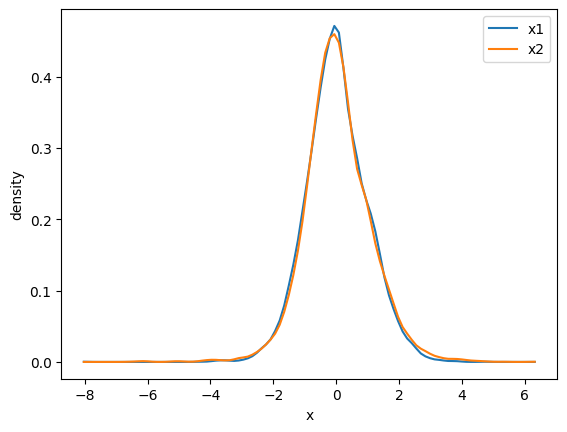

In [21]:
from scipy.stats import gaussian_kde

# TODO: Make code that automatically slices these up.
theta_test = jnp.expand_dims(X[:, X.shape[1] // 2], -1)
# d_test = jnp.expand_dims(X[:, 4], -1)
d_test = X[:, -len_x:-len_xi]
xi_test = X[:, -len_xi:]
# xi_test = jnp.expand_dims(X[:, 2], -1)
# xi_test = jnp.ones((10000, 1)) * 3
# xi_test = jnp.expand_dims(X[:, 1], -1)


samples = model_sample.apply(params, 
                    next(prng_seq),
                    num_samples=len(theta_test),
                    theta=theta_test,
                    d=d_test,
                    # d=d_obs,
                    xi=xi_test)


density_1 = gaussian_kde(samples[:, 0])
density_2 = gaussian_kde(samples[:, 1])


# Plot the density
fig, ax = plt.subplots()
x = np.linspace(jnp.min(samples), jnp.max(samples), 100)
ax.plot(x, density_1(x), label='x1')
ax.plot(x, density_2(x), label='x2')
plt.xlabel('x')
plt.ylabel('density')
plt.legend()
plt.show()

## LFI-ACE
Manually trained and stepped-through LFI-ACE model.

1. Approximate likelihood using normalizing flow. Use a bunch of samples and their corresponding $\theta$ values. Also, since the `pyro` version only uses one noise element, get rid of the other one that Kleinegesse used.
2. Use approximated likelihood in ACE computation.
3. Approximate the likelihood using LFI-ACE.

This is code where i'm experimenting with the `update`, `loss`, and `params` stuff.

In [18]:
def sim_linear_jax(d: Array, priors: Array, key: PRNGKey):
    # Keys for the appropriate functions
    keys = jrandom.split(key, 3)

    # sample random normal dist
    noise_shape = (1,)

    mu_noise = jnp.zeros(noise_shape)
    sigma_noise = jnp.ones(noise_shape)

    n_n = distrax.Independent(
        distrax.MultivariateNormalDiag(mu_noise, sigma_noise)
    ).sample(seed=keys[0], sample_shape=[len(d), len(priors)])

    # sample random gamma noise
    n_g = distrax.Gamma(2.0, 1.0 / 2.0).sample(
        seed=keys[1], sample_shape=[len(d), len(priors)]
    )

    # forward pass
    y = jnp.broadcast_to(priors[:, 0], (len(d), len(priors)))
    y = y + jnp.expand_dims(d, 1) @ jnp.expand_dims(priors[:, 1], 0)
    y = y + n_g + jnp.squeeze(n_n)
    ygrads = priors[:, 1]

    return y, ygrads


def sim_data(d: Array, priors: Array, key: PRNGKey):
    """
    Returns data in a format suitable for normalizing flow training.
    Data will be in shape [y, thetas]. The `y` variable can vary in size.
    """
    keys = jrandom.split(key, 2)

    theta_shape = (2,)

    mu = jnp.zeros(theta_shape)
    sigma = (3**2) * jnp.ones(theta_shape)

    base_distribution = distrax.Independent(  # Should this be independent?
        distrax.MultivariateNormalDiag(mu, sigma)
    )

    priors = base_distribution.sample(seed=keys[0], sample_shape=[num_samples])

    # ygrads allows to be compared to other implementations (Kleinegesse et)
    y, ygrads = sim_linear_jax(d, priors, keys[1])

    return jnp.column_stack(
        (y.T, jnp.squeeze(priors), jnp.broadcast_to(d, (num_samples, len(d))))
    )

def lfi_ace_loss_fn(
    params: hk.Params, prng_key: PRNGKey, x: Array, theta: Array, d: Array, xi: Array, 
    M: int, prior_dists, 
) -> Array:
    loss = -jnp.mean(log_prob.apply(params, x, theta, d, xi))
    return loss


def sim_linear_prior(num_samples: int, key: PRNGKey):
    """
    Simulate prior samples and return their log_prob.
    """
    theta_shape = (2,)

    mu = jnp.zeros(theta_shape)
    sigma = (3**2) * jnp.ones(theta_shape)

    base_distribution = distrax.Independent(  # Should this be independent?
        distrax.MultivariateNormalDiag(mu, sigma)
    )

    samples, log_prob = base_distribution.sample_and_log_prob(seed=key, sample_shape=[num_samples])

    return samples, log_prob


def lfi_pce_loss_fn(
    params: hk.Params, prng_key: PRNGKey, x: Array, theta: Array, d: Array, num_samples: int, # xi: Array, 
    M: int #, prior_dist: Distribution
) -> Array:
    keys = jrandom.split(prng_key, 2)
    xi = params['xi']
    flow_params = {k: v for k, v in params.items() if k != 'xi'}
    # theta_0 = prior_dist.sample((num_samples, 1))
    # simulate the outcomes before finding their log_probs
    d_sim = jnp.concatenate((d, xi), axis=0)
    X = sim_data(d_sim, num_samples, keys[0])  # Do I need to split up the prng_key?

    # I'm implicitly returning the prior here, that's a little annoying...
    x, theta_0, d, xi = prepare_data(X)  # TODO: Maybe refactor this?

    conditional_lp = log_prob.apply(flow_params, x, theta_0, d, xi)
    # theta_L = prior_dist.sample((num_samples, M-1))
    # Need to make an array of the new theta values
    
    contrastive_lps = []
    for _ in range(M):
        theta, _ = sim_linear_prior(num_samples, keys[1])
        contrastive_lp = log_prob.apply(flow_params, x, theta, d, xi)
        contrastive_lps.append(contrastive_lp)

    marginal_log_prbs = jnp.concatenate((conditional_lp, jnp.array(contrastive_lps)))

    marginal_lp = jax.nn.logsumexp(marginal_log_prbs, -1) - math.log(num_samples)

    return _safe_mean_terms(conditional_lp - marginal_lp)


    
    theta_L = jnp.concatenate((theta_0, theta_L), axis=-1)
    flow_loss = -jnp.mean(likelihood_0)
    likelihood_L = log_prob.apply(flow_params, x, theta_L, d, xi)

    marginal = jax.nn.logsumexp(likelihoods, -1) - math.log(num_samples)
    eig_estimate = (likelihoods.exp() * (likelihoods - marginal)).sum(-1).mean(0)
    surrogate_loss = eig_estimate.sum() + flow_loss
    return surrogate_loss, eig_estimate

    # Take N samples of the model
    expanded_design = lexpand(design, N)  # N copies of the model
    trace = poutine.trace(model).get_trace(expanded_design)
    trace.compute_log_prob()
    conditional_lp = sum(trace.nodes[l]["log_prob"] for l in observation_labels)

    y_dict = {l: lexpand(trace.nodes[l]["value"], M) for l in observation_labels}
    # Resample M values of theta and compute conditional probabilities
    conditional_model = pyro.condition(model, data=y_dict)
    # Using (M, 1) instead of (M, N) - acceptable to re-use thetas between ys because
    # theta comes before y in graphical model
    reexpanded_design = lexpand(design, M, 1)  # sample M theta
    retrace = poutine.trace(conditional_model).get_trace(reexpanded_design)
    retrace.compute_log_prob()
    marginal_log_probs = torch.cat([lexpand(conditional_lp, 1),
                                    sum(retrace.nodes[l]["log_prob"] for l in observation_labels)])
    marginal_lp = marginal_log_probs.logsumexp(0) - math.log(M+1)

    return _safe_mean_terms(conditional_lp - marginal_lp)


@jax.jit
def update(
    params: hk.Params, prng_key: PRNGKey, opt_state: OptState, batch: Batch
) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    x, theta, d, xi = prepare_data(batch)
    grads = jax.grad(loss_fn)(params, prng_key, x, theta, d, xi)
    # grads_d = jax.grad(loss_fn, argnums=5)(params, prng_key, x, theta, d, xi)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state



## Doing it completely manual
Just to work out the bugs ;)

In [5]:
from collections import deque

def sim_linear_prior(num_samples: int, key: PRNGKey):
    """
    Simulate prior samples and return their log_prob.
    """
    theta_shape = (2,)

    mu = jnp.zeros(theta_shape)
    sigma = (3**2) * jnp.ones(theta_shape)

    base_distribution = distrax.Independent(  # Should this be independent?
        distrax.MultivariateNormalDiag(mu, sigma)
    )

    samples, log_prob = base_distribution.sample_and_log_prob(seed=key, sample_shape=[num_samples])

    return samples, log_prob

def jax_lexpand(A, *dimensions):
    """Expand tensor, adding new dimensions on left."""
    if jnp.isscalar(A):
        A = A * jnp.ones(dimensions)
        return A
    shape = tuple(dimensions) + A.shape
    A = A[jnp.newaxis, ...]
    A = jnp.broadcast_to(A, shape)
    return A


def lfi_pce_eig(params: hk.Params, prng_key: PRNGKey, N: int=100, M: int=10, **kwargs):
    keys = jrandom.split(prng_key, 3 + M)
    xi = jnp.squeeze(params['xi'])
    flow_params = {k: v for k, v in params.items() if k != 'xi'}

    # simulate the outcomes before finding their log_probs
    X = sim_data(d_sim, num_samples, keys[0])  # Do I need to split up the prng_key?

    # I'm implicitly returning the prior here, that's a little annoying...
    x, theta_0, d, xi = prepare_data(X)  # TODO: Maybe refactor this?

    conditional_lp = log_prob.apply(flow_params, x, theta_0, d, xi)

    contrastive_lps = []
    thetas = []
    # TODO: can this be parallelized to speed up the computation?
    for i in range(M):
        theta, _ = sim_linear_prior(num_samples, keys[i + 1])
        thetas.append(theta)
        contrastive_lp = log_prob.apply(flow_params, x, theta, d, xi)
        contrastive_lps.append(contrastive_lp)

    marginal_log_prbs = jnp.concatenate((jax_lexpand(conditional_lp, 1), jnp.array(contrastive_lps)))

    marginal_lp = jax.nn.logsumexp(marginal_log_prbs, 0) - math.log(M + 1)

    return sum(conditional_lp - marginal_lp) - jnp.mean(contrastive_lp)


@jax.jit
def update_pce(
    params: hk.Params, prng_key: PRNGKey, opt_state: OptState, N: int, M: int
) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    grads = jax.grad(lfi_pce_eig)(params, prng_key, N=num_samples, M=inner_samples)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state


# Boilerplate setup
seed = 1231
M = 10
key = jrandom.PRNGKey(seed)

d = jnp.array([0.])
xi = jnp.array([0.1])
if d.size == 0:
    d_sim = xi
else:
    d_sim = jnp.concatenate((d, xi), axis=0)
# d_sim = jnp.concatenate((d, xi), axis=0)

# Params and hyperparams
len_x = len(d_sim)
len_d = len(d)
len_xi = len(xi)

theta_shape = (2,)
d_shape = (len(d),)
xi_shape = (len_xi,)
EVENT_SHAPE = (len(d_sim),)
# EVENT_DIM is important for the normalizing flow's block.
EVENT_DIM = 1
cond_info_shape = (theta_shape[0], len_d, len_xi)

num_samples = 10
inner_samples = 10 # AKA M or L in BOED parlance
batch_size = 128
flow_num_layers = 5 #3 # 10
mlp_num_layers = 1 # 3 # 4
hidden_size = 8 # 128 # 500
num_bins = 4
learning_rate = 1e-4
warmup_steps = 10
early_stopping_memory = 10
early_stopping_threshold = 5e-2

training_steps = 100
eval_frequency = 5

# Initialzie the params
prng_seq = hk.PRNGSequence(42)  # TODO: Put one of "keys" here?
params = log_prob.init(
    next(prng_seq),
    np.zeros((1, *EVENT_SHAPE)),
    np.zeros((1, *theta_shape)),
    np.zeros((1, *d_shape)),
    np.zeros((1, *xi_shape)),
)
# init_params = params.copy()
params['xi'] = xi

optimizer = optax.adam(learning_rate)

opt_state = optimizer.init(params)

# TODO: put this function in training since d will be changing.
# num_samples = 10000
# X = sim_data(d_sim, num_samples, key)

# shift = X.mean(axis=0)
# scale = X.std(axis=0) + 1e-14

# # Create tf dataset from sklearn dataset
# dataset = tf.data.Dataset.from_tensor_slices(X)

# # Splitting into train/validate ds
# train = dataset.skip(2000)
# val = dataset.take(2000)

# # load_dataset(split: tfds.Split, batch_size: int)
# train_ds = load_dataset(train, 512)
# valid_ds = load_dataset(val, 512)
# print(params)
# loss_deque = deque(maxlen=early_stopping_memory)
# for step in range(training_steps):
#     params, opt_state = update_pce(
#         params, next(prng_seq), opt_state, N=num_samples, M=M
#     )
#     # params, opt_state, grads_d = update(
#     #     params, next(prng_seq), opt_state, next(train_ds)
#     # )

#     print(f"STEP: {step:5d}; Xi: {params['xi']}")
    # if step % eval_frequency == 0:
    #     val_loss = eval_fn(params, next(valid_ds))
    #     print(f"STEP: {step:5d}; Validation loss: {val_loss:.3f}")
    
    #     loss_deque.append(val_loss)
    #     avg_abs_diff = jnp.mean(abs(jnp.array(loss_deque) - sum(loss_deque)/len(loss_deque)))
    #     if step > warmup_steps and avg_abs_diff < early_stopping_threshold:
    #         break

In [147]:
grads["xi"] = grads_xi
updates, new_opt_state = optimizer.update(grads, opt_state)
new_params = optax.apply_updates(params, updates)

In [ ]:
params['conditioner_module/mlp/~/linear_0']

In [105]:
lfi_pce_eig(params, key, N=num_samples, M=M)

DeviceArray(3.6019292, dtype=float32)

In [108]:
grads = jax.grad(lfi_pce_eig)(params, key, N=num_samples, M=M)

In [109]:
updates, new_opt_state = optimizer.update(grads, opt_state)
new_params = optax.apply_updates(params, updates)

In [7]:
params = log_prob.init(
    next(prng_seq),
    np.zeros((1, *EVENT_SHAPE)),
    np.zeros((1, *theta_shape)),
    np.zeros((1, *d_shape)),
    np.zeros((1, *xi_shape)),
)
# init_params = params.copy()
params['xi'] = xi

In [10]:
M = 10
keys = jrandom.split(key, 3 + M)
num_samples = 10

xi = params['xi']
flow_params = {k: v for k, v in params.items() if k != 'xi'}

X = sim_data(d_sim, num_samples, keys[0])  # Do I need to split up the prng_key?

# I'm implicitly returning the prior here, that's a little annoying...
x, theta_0, d, xi = prepare_data(X)

contrastive_lps = []
thetas = []
for i in range(M):
    theta, _ = sim_linear_prior(num_samples, keys[i + 1])
    thetas.append(theta)
    contrastive_lp = log_prob.apply(flow_params, x, theta, d, xi)
    contrastive_lps.append(contrastive_lp)


In [14]:
thetas

[DeviceArray([[  0.64793307,  12.057756  ],
              [ -1.8036    , -21.126171  ],
              [  1.133066  ,  11.62901   ],
              [ -4.5348973 ,  -7.0127087 ],
              [ -5.4115043 ,  -3.4683409 ],
              [ -7.423147  ,   7.645422  ],
              [  1.5872409 ,  11.221082  ],
              [  0.8586352 , -10.206353  ],
              [  8.100239  ,  -6.1539264 ],
              [-13.176195  ,  10.821227  ]], dtype=float32),
 DeviceArray([[ -6.1988173 ,  -1.2310148 ],
              [-12.849492  , -12.620625  ],
              [ -7.4009905 ,  -3.9226563 ],
              [ 17.474777  ,  14.818273  ],
              [  6.0482283 ,   6.752823  ],
              [ 13.28307   ,  -1.4132088 ],
              [ -2.7293384 ,   3.487775  ],
              [  7.874885  ,  -0.23380284],
              [-14.064912  ,  11.756083  ],
              [  2.0690577 ,  14.524533  ]], dtype=float32),
 DeviceArray([[ -3.65689  ,   7.231424 ],
              [ -1.9369462,   1.1989701],
  

In [66]:
thetas[0]

DeviceArray([[  0.64793307,  12.057756  ],
             [ -1.8036    , -21.126171  ],
             [  1.133066  ,  11.62901   ],
             [ -4.5348973 ,  -7.0127087 ],
             [ -5.4115043 ,  -3.4683409 ],
             [ -7.423147  ,   7.645422  ],
             [  1.5872409 ,  11.221082  ],
             [  0.8586352 , -10.206353  ],
             [  8.100239  ,  -6.1539264 ],
             [-13.176195  ,  10.821227  ]], dtype=float32)

In [67]:
log_prob.apply(flow_params, x, thetas[0], d, xi)

DeviceArray([-3.253583 , -3.9614515, -3.3008242, -3.7383153, -3.2508907,
             -3.7140958, -3.7958465, -3.1544094, -4.623407 , -3.2264678],            dtype=float32)

In [69]:
thetas[1]

DeviceArray([[ -6.1988173 ,  -1.2310148 ],
             [-12.849492  , -12.620625  ],
             [ -7.4009905 ,  -3.9226563 ],
             [ 17.474777  ,  14.818273  ],
             [  6.0482283 ,   6.752823  ],
             [ 13.28307   ,  -1.4132088 ],
             [ -2.7293384 ,   3.487775  ],
             [  7.874885  ,  -0.23380284],
             [-14.064912  ,  11.756083  ],
             [  2.0690577 ,  14.524533  ]], dtype=float32)

In [70]:
log_prob.apply(flow_params, x, thetas[1], d, xi)

DeviceArray([-3.253583 , -3.9614515, -3.3008242, -3.7383153, -3.2508907,
             -3.7140958, -3.7958465, -3.1544094, -4.623407 , -3.2264678],            dtype=float32)

In [64]:
contrastive_lps[0] == contrastive_lps[4]
# wtf? get back to this later.

DeviceArray([ True,  True,  True,  True,  True,  True,  True,  True,
              True,  True], dtype=bool)

In [55]:
marginal_log_prbs = jnp.concatenate((jax_lexpand(conditional_lp, 1), jnp.array(contrastive_lps)))

In [56]:
marginal_log_prbs.shape  # This may need to have an extra dimension

(11, 10)

In [72]:
import math
marginal_lp = jax.nn.logsumexp(marginal_log_prbs, 0) - math.log(M + 1)

In [75]:
# marginal_log_prbs -> marginal_lp needs to be over 0th dimension to remove 11
marginal_lp.shape

(10,)

In [71]:
conditional_lp.shape  # Think this needs to be a 1D array not scalar

(10,)

In [74]:
conditional_lp - marginal_lp

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [61]:
def _safe_mean_terms(terms):
    mask = torch.isnan(terms) | (terms == float('-inf')) | (terms == float('inf'))
    if terms.dtype is torch.float32:
        nonnan = (~mask).sum(0).float()
    elif terms.dtype is torch.float64:
        nonnan = (~mask).sum(0).double()
    terms[mask] = 0.
    loss = terms.sum(0) / nonnan
    agg_loss = loss.sum()
    return agg_loss, loss

In [5]:
params.keys()

dict_keys(['conditioner_module/linear', 'conditioner_module/linear_1', 'conditioner_module/linear_2', 'conditioner_module/linear_3', 'conditioner_module/linear_4', 'conditioner_module/mlp/~/linear_0', 'conditioner_module/mlp_1/~/linear_0', 'conditioner_module/mlp_2/~/linear_0', 'conditioner_module/mlp_3/~/linear_0'])

In [19]:
params['xi'] = 1

In [20]:
params.keys()

dict_keys(['conditioner_module/linear', 'conditioner_module/linear_1', 'conditioner_module/linear_2', 'conditioner_module/linear_3', 'conditioner_module/linear_4', 'conditioner_module/mlp/~/linear_0', 'conditioner_module/mlp_1/~/linear_0', 'conditioner_module/mlp_2/~/linear_0', 'conditioner_module/mlp_3/~/linear_0', 'xi'])

In [21]:
testy = params.pop('xi', None)

In [22]:
params.keys()

dict_keys(['conditioner_module/linear', 'conditioner_module/linear_1', 'conditioner_module/linear_2', 'conditioner_module/linear_3', 'conditioner_module/linear_4', 'conditioner_module/mlp/~/linear_0', 'conditioner_module/mlp_1/~/linear_0', 'conditioner_module/mlp_2/~/linear_0', 'conditioner_module/mlp_3/~/linear_0'])

In [23]:
testy

1

Time to train. Just need a vector of the samples and thetas that produced them. Don't need a simulator or the prior quite yet.
- How do I track the training curves in Jax/Haiku? Gave in and am using WANDB.

In [13]:
# import wandb

# wandb.init(project="lfiax_linRegression_ACE", entity="vz_uci")

# TODO: Put this in hydra config file
seed = 1231
key = jrandom.PRNGKey(seed)

# d = jnp.array([-10.0, 0.0, 5.0, 10.0])
# d = jnp.array([1., 2.])
# d = jnp.array([1.])
# d_obs = jnp.array([0.])
d_obs = jnp.array([])
# d_prop = jrandom.uniform(key, shape=(1,), minval=-10.0, maxval=10.0)
xi = jnp.array([0.])
# d_prop = jnp.array([])
d_sim = jnp.concatenate((d_obs, xi), axis=0)
len_x = len(d_sim)
len_d = len(d_obs)
len_xi = len(xi)
num_samples = 100

# Params and hyperparams
theta_shape = (2,)
d_shape = (len(d_obs),)
xi_shape = (len_xi,)
EVENT_SHAPE = (len(d_sim),)
# EVENT_DIM is important for the normalizing flow's block.
EVENT_DIM = 1
cond_info_shape = (theta_shape[0], len_d, len_xi)

batch_size = 128
flow_num_layers = 5 #3 # 10
mlp_num_layers = 4 # 3 # 4
hidden_size = 128 # 500
num_bins = 4
learning_rate = 1e-4
warmup_steps = 100
early_stopping_memory = 10
early_stopping_threshold = 5e-2

training_steps = 500
eval_frequency = 10

optimizer = optax.adam(learning_rate)

# Simulating the data to be used to train the flow.
num_samples = 10000
# TODO: put this function in training since d will be changing.
X = sim_data(d_sim, num_samples, key)

shift = X.mean(axis=0)
scale = X.std(axis=0) + 1e-14

# Create tf dataset from sklearn dataset
dataset = tf.data.Dataset.from_tensor_slices(X)

# Splitting into train/validate ds
train = dataset.skip(2000)
val = dataset.take(2000)

# load_dataset(split: tfds.Split, batch_size: int)
train_ds = load_dataset(train, 512)
valid_ds = load_dataset(val, 512)

# Training
prng_seq = hk.PRNGSequence(42)
params = log_prob.init(
    next(prng_seq),
    np.zeros((1, *EVENT_SHAPE)),
    np.zeros((1, *theta_shape)),
    np.zeros((1, *d_shape)),
    np.zeros((1, *xi_shape)),
)
params['xi'] = xi
opt_state = optimizer.init(params)

# Can change the length of the deque for more/less leniency in measuring the loss
loss_deque = deque(maxlen=early_stopping_memory)
for step in range(training_steps):
    params, opt_state, grads_d = update(
        params, next(prng_seq), opt_state, next(train_ds)
    )

    if step % eval_frequency == 0:
        val_loss = eval_fn(params, next(valid_ds))
        print(f"STEP: {step:5d}; Validation loss: {val_loss:.3f}")
    
        loss_deque.append(val_loss)
        avg_abs_diff = jnp.mean(abs(jnp.array(loss_deque) - sum(loss_deque)/len(loss_deque)))
        if step > warmup_steps and avg_abs_diff < early_stopping_threshold:
            break


STEP:     0; Validation loss: 9.587
STEP:    10; Validation loss: 9.453
STEP:    20; Validation loss: 9.295
STEP:    30; Validation loss: 9.160
STEP:    40; Validation loss: 8.990
STEP:    50; Validation loss: 8.950
STEP:    60; Validation loss: 8.914
STEP:    70; Validation loss: 8.899
STEP:    80; Validation loss: 8.833
STEP:    90; Validation loss: 8.782
STEP:   100; Validation loss: 8.803
STEP:   110; Validation loss: 8.844
STEP:   120; Validation loss: 8.850
STEP:   130; Validation loss: 8.681
STEP:   140; Validation loss: 8.731
STEP:   150; Validation loss: 8.693
STEP:   160; Validation loss: 8.693
STEP:   170; Validation loss: 8.739
STEP:   180; Validation loss: 8.609
STEP:   190; Validation loss: 8.722
STEP:   200; Validation loss: 8.581
STEP:   210; Validation loss: 8.620
STEP:   220; Validation loss: 8.705


In [16]:
params['xi']

DeviceArray([10.], dtype=float32)

In [46]:
d_prop.shape

(1,)

Making the sampling/log-prob stuff work. Now to actually implment LFI ACE. I've got the flow, now just going to do some of the ACE computations manually.

In [ ]:
def jax_lexpand(A, *dimensions):
    """Expand tensor, adding new dimensions on left."""
    if jnp.isscalar(A):
        A = A * jnp.ones(dimensions)
        return A
    shape = tuple(dimensions) + A.shape
    A = A[jnp.newaxis, ...]
    A = jnp.broadcast_to(A, shape)
    return A


# Walking through and commenting the code
def lfi_ace_eig_loss(model:NormalizingFlow, guide:NormalizingFlow, M, observation_labels, target_labels):
    def loss_fn(design, num_particles, evaluation=False, **kwargs):
        N = num_particles
        # Expand to the number of parallel designs being evaluated
        expanded_design = lexpand(design, N)
        
        # TODO: make a for loop over the proposed models here.
        for model in models:
            # TODO: would be cool to make sampling from the model's prior a method
             # Hmm I need N copies for parallelization. I can figure that out later, though.
            model_thetas_0 = model.prior_distribution.sample(num_samples)
            y_0, log_prob_y_0 = model.sample_with_log_prob(model_thetas_0, expanded_design)
            # Get a dictionary of the expanded y and theta values, just make M copies of y values
            # TODO: think of a better way to add these into expanded dictionary values...
            y_dict_exp = lexpand(y, M)

            # This is essentially the p(y|theta)p(theta)
            # Ohh, each model will have two ratios, it's current prob and its prior one
            marginal_terms_cross = sum(model.prior_distribution.log_prob(model_thetas_0))
            marginal_terms_cross += sum(log_prob_y_0)

        # Pray that jax can handle this parallelization - vmap and pmap to the rescue!...?
        for _ in range(m):
            for model in models:
                # Sample from q(theta | y, d) using the guide normalizing flow
                theta, log_prob = guide.sample_with_log_prob(y, expanded_design, observation_labels, target_labels)
                theta_y_dict = {l: theta[l] for l in target_labels}
                theta_y_dict.update(y_dict_exp)

                marginal_terms_proposal = -sum(log_prob[l] for l in target_labels)
                marginal_terms_proposal += sum(log_prob[l] for l in target_labels)
                marginal_terms_proposal += sum(log_prob[l] for l in observation_labels)

                marginal_terms = torch.cat([lexpand(marginal_terms_cross, 1), marginal_terms_proposal])
                terms = -marginal_terms.logsumexp(0) + math.log(M + 1)

                # At eval time, add p(y | theta, d) terms
                if evaluation:
                    terms += sum(log_prob[l] for l in observation_labels)
                return _safe_mean_terms(terms)

        # Sample from q(theta | y, d) using the guide normalizing flow
        theta, log_prob = guide.sample_with_log_prob(y, expanded_design, observation_labels, target_labels)
        theta_y_dict = {l: theta[l] for l in target_labels}
        theta_y_dict.update(y_dict_exp)

        marginal_terms_proposal = -sum(log_prob[l] for l in target_labels)
        marginal_terms_proposal += sum(log_prob[l] for l in target_labels)
        marginal_terms_proposal += sum(log_prob[l] for l in observation_labels)

        marginal_terms = torch.cat([lexpand(marginal_terms_cross, 1), marginal_terms_proposal])
        terms = -marginal_terms.logsumexp(0) + math.log(M + 1)

        # At eval time, add p(y | theta, d) terms
        if evaluation:
            terms += sum(log_prob[l] for l in observation_labels)
        return _safe_mean_terms(terms)

    return loss_fn


In [111]:
device = 'cpu'
p = 20
n = 20
N = 2 # num_parallel
M = 2
design = torch.zeros([10, 20, 20])
expanded_design = lexpand(design, N)

w_prior_loc = torch.zeros(p, device=device)
w_prior_scale = scale * torch.ones(p, device=device)
sigma_prior_scale = scale * torch.tensor(1., device=device)

model_learn_xi = make_regression_model(
    w_prior_loc, w_prior_scale, sigma_prior_scale, xi_init)

model = model_learn_xi
guide = PosteriorGuide(n, p, (N,)).to(device)
observation_labels = ["y"]
target_labels = ['w', 'sigma']

In [91]:
trace = poutine.trace(model).get_trace(expanded_design)
y_dict_exp = {l: lexpand(trace.nodes[l]["value"], M) for l in observation_labels}
y_dict = {l: trace.nodes[l]["value"] for l in observation_labels}
theta_dict = {l: trace.nodes[l]["value"] for l in target_labels}

In [101]:
y_dict['y'].shape

torch.Size([2, 10, 20])

In [104]:
theta_dict['w'].shape

torch.Size([2, 10, 20])

In [105]:
theta_dict['sigma'].shape

torch.Size([2, 10])

In [107]:
[trace.nodes[l]["log_prob"].shape for l in target_labels]

[torch.Size([2, 10]), torch.Size([2, 10])]

That's what's throwing me off. Determining the `log_prob` of the `w` vector compresses it for some reason... Oh, wait, it's the probability of each *vector*. That's why it's compressed to the shape of the `y` and `sigma` shapes. Yea, that makes a lot more sense.

In [92]:
trace.compute_log_prob()
# This is taking the log_prob of a vector from a distribution. I can either use a distribution that 
# is in a vector format or I think it should be fine to add two separate ones together...
marginal_terms_cross = sum(trace.nodes[l]["log_prob"] for l in target_labels)

In [108]:
marginal_terms_cross += sum(trace.nodes[l]["log_prob"] for l in observation_labels)

In [109]:
marginal_terms_cross

tensor([[-48.1695, -70.6690, -58.5410, -57.8346, -82.7463, -79.5401, -34.3802,
         -75.5568, -62.8853, -90.3731],
        [-68.9690, -46.9697, -79.1669, -81.4540, -75.3442, -28.8084, -77.4504,
         -67.5315,   2.8248, -70.4339]], grad_fn=<AddBackward0>)

This next part would be the denominator of LFI-ACE with the sum of all of the models' log_probs. The numerator might actually be the sum of all the log_probs. The denominator would be the weighted sum... Yea, that makes more sense....

Part of the loss could then just be adding on the loss of the prediction of each normalizing flow. That makes one scalar loss. Although, there's an EIG for each of the 'y' outputs, too.

In [112]:
reguide_trace = poutine.trace(
    pyro.condition(guide, data=theta_dict)).get_trace(
    y_dict, expanded_design, observation_labels, target_labels)
# Here's a spot where you could update each model's parameters based on log_prob
reguide_trace.compute_log_prob()
marginal_terms_cross -= sum(reguide_trace.nodes[l]["log_prob"] for l in target_labels)
marginal_terms_cross

RuntimeError: The size of tensor a (2) must match the size of tensor b (10) at non-singleton dimension 1
Trace Shapes:
 Param Sites:
Sample Sites:

In [ ]:
trace = poutine.trace(model).get_trace(expanded_design)
y_dict_exp = {l: lexpand(trace.nodes[l]["value"], M) for l in observation_labels}
y_dict = {l: trace.nodes[l]["value"] for l in observation_labels}
theta_dict = {l: trace.nodes[l]["value"] for l in target_labels}

trace.compute_log_prob()
marginal_terms_cross = sum(trace.nodes[l]["log_prob"] for l in target_labels)
marginal_terms_cross += sum(trace.nodes[l]["log_prob"] for l in observation_labels)

reguide_trace = poutine.trace(
    pyro.condition(guide, data=theta_dict)).get_trace(
    y_dict, expanded_design, observation_labels, target_labels)
# Here's a spot where you could update each model's parameters based on log_prob
reguide_trace.compute_log_prob()
marginal_terms_cross -= sum(reguide_trace.nodes[l]["log_prob"] for l in target_labels)

# Sample M times from q(theta | y, d) for each y
reexpanded_design = lexpand(expanded_design, M)
guide_trace = poutine.trace(guide).get_trace(
    y_dict, reexpanded_design, observation_labels, target_labels
)
theta_y_dict = {l: guide_trace.nodes[l]["value"] for l in target_labels}
theta_y_dict.update(y_dict_exp)
guide_trace.compute_log_prob()

# Re-run that through the model to compute the joint
model_trace = poutine.trace(
pyro.condition(model, data=theta_y_dict)).get_trace(reexpanded_design)
model_trace.compute_log_prob()

marginal_terms_proposal = -sum(guide_trace.nodes[l]["log_prob"] for l in target_labels)
marginal_terms_proposal += sum(model_trace.nodes[l]["log_prob"] for l in target_labels)
marginal_terms_proposal += sum(model_trace.nodes[l]["log_prob"] for l in observation_labels)

marginal_terms = torch.cat([lexpand(marginal_terms_cross, 1), marginal_terms_proposal])
terms = -marginal_terms.logsumexp(0) + math.log(M + 1)

# At eval time, add p(y | theta, d) terms
# if evaluation:
terms += sum(trace.nodes[l]["log_prob"] for l in observation_labels)
# breakpoint()
_safe_mean_terms(terms)
